<a href="https://colab.research.google.com/github/jash-ai/Finance/blob/main/%5B2025_01_18%5D_Updated_AI_%26_Stock_Market_Workshop_tsla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data to Dollars AI & Stock Market
https://www.youtube.com/watch?v=DZwYsCkmRcE
python notebook
https://colab.research.google.com/drive/1l8ZqFhy08v9StF0JrUqnPhQ3CivVcf3L?usp=sharing


# From Data to Dollars: AI & Stock Market
Welcome to this workshop! Here, we'll explore how AI techniques can be applied to stock market data to generate insights and build forecasting models. This notebook is designed to help data scientists and finance enthusiasts with an interest in AI/ML to take the first steps to Stock Market Forecasting.

This notebook is a highly condensed demonstration of a full, 12-week course on the topic of AI and the Stock Market. With more time, we will cover more finance and stock fundamentals, machine learning, and developing AI tools for classic analysis of stocks (e.g. building our own dynamic DCF models).

By the end of this session, you'll understand how to process raw data, engineer useful features, and evaluate forecasting approaches.

## Introduction to Stock Market Data and Forecasting
Stock market forecasting involves predicting future stock prices or trends based on historical data. Accurate predictions can guide investment decisions! While these models may not help us beat the market, they do give us the first fundamental steps to building systems that can help predict short-term price movements.

One Important Principle to Keep in-Mind: Over the long-term, stock prices follow **Expected Earnings**.

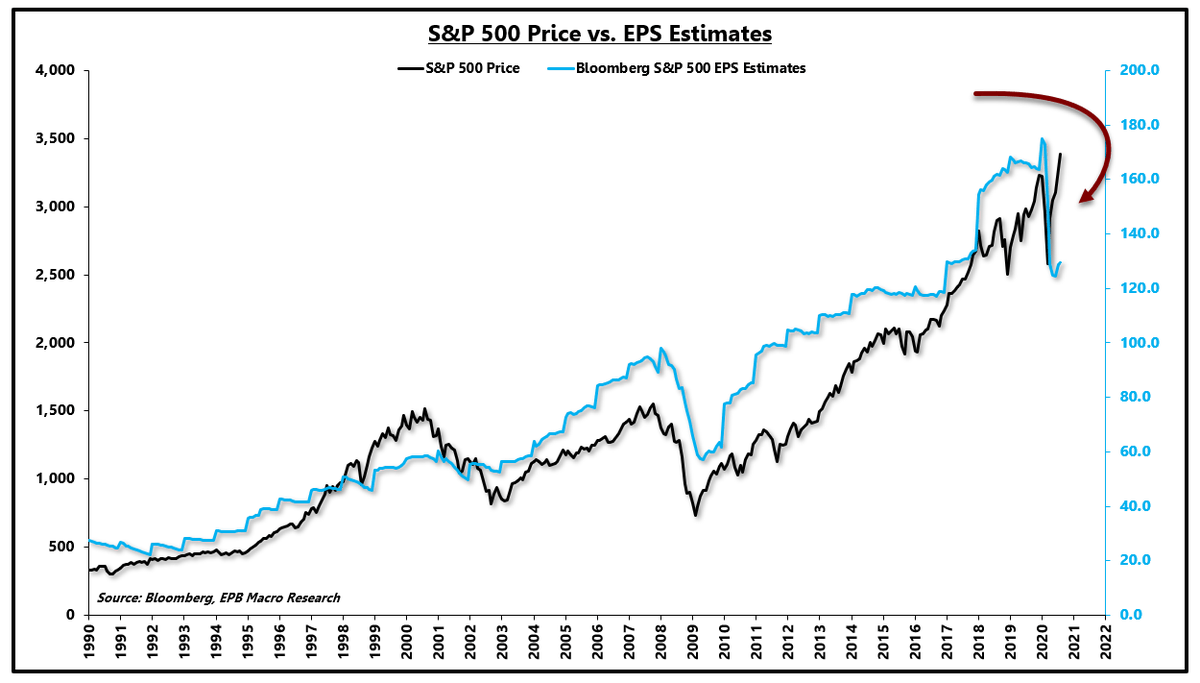

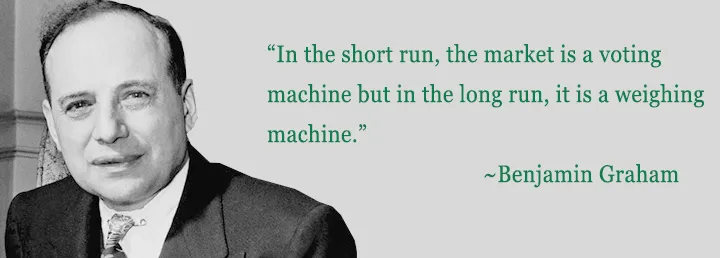

What that means for turning Data to Dollars: We can use historical data to help forecast what a stock might do in the short term. However, in the long-term, we need a different kind of modeling - one that forecasts how a company's earnings (i.e. their profits) will grow over time. Ultimately, stock prices follow earnings!

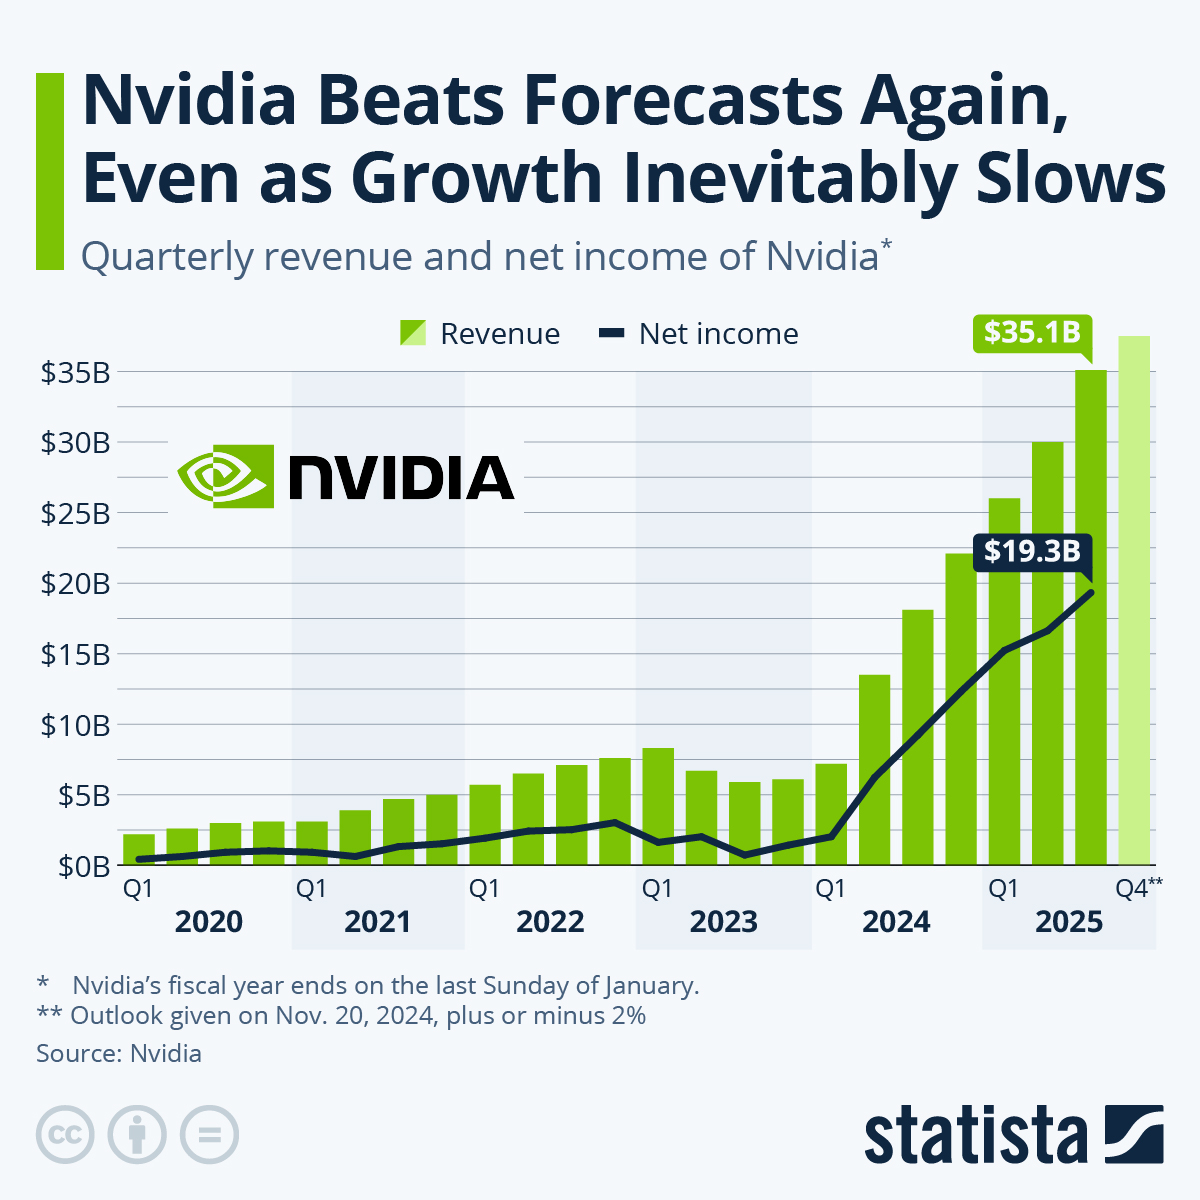

### Overview of Forecasting
Still, we may want to participate in some short/medium term trading, and potentially find patterns and algorithms in the market. At the very least, it's useful to have a baseline for predicting price and what factors historically cause these moves.

Let's review common forecasting methods and introduce the tools and techniques we'll use to analyze stock market data. These approaches include statistical models and modern AI techniques.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from datetime import datetime

#Link to get API key for FRED: https://fredaccount.stlouisfed.org/login/secure/

api_key = "52df47c3ce74f3f7da3162787aa98af9" # enter API key for FRED data
ticker = "TSLA"
start_date="2021-01-01"
end_date="2025-01-18"

### Load Dataset
We will use stock market data retrieved from Yahoo Finance via the `yfinance` library. This data includes historical prices for major stocks, which forms the foundation for our forecasting models.

Data is at the heart of any and all Investment decisions, whichever type of modeling you will use. Once you have a clean data pipeline together, then you have countless options to model and forecast. Without data, we can't even participate.

In [2]:
# Load stock market data using yfinance
def load_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date, end=end_date)
    stock_data = stock_data.reset_index()[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.tz_localize(None)
    # stock_data.reset_index(inplace=True)
    return stock_data

# Fetch data for PLTR
stock_data = load_stock_data(ticker, start_date, end_date)

# Display the first few rows of the stock data
stock_data.head()

,Date,Close,Open,High,Low,Volume
0,2021-01-04,243.256668,239.820007,248.163330,239.063339,145914600
1,2021-01-05,245.036667,241.220001,246.946671,239.733337,96735600
2,2021-01-06,251.993332,252.830002,258.000000,249.699997,134100000
3,2021-01-07,272.013336,259.209991,272.329987,258.399994,154496700
4,2021-01-08,293.339996,285.333344,294.829987,279.463318,225166500


In [3]:
stock_data

,Date,Close,Open,High,Low,Volume
0,2021-01-04,243.256668,239.820007,248.163330,239.063339,145914600
1,2021-01-05,245.036667,241.220001,246.946671,239.733337,96735600
2,2021-01-06,251.993332,252.830002,258.000000,249.699997,134100000
3,2021-01-07,272.013336,259.209991,272.329987,258.399994,154496700
4,2021-01-08,293.339996,285.333344,294.829987,279.463318,225166500
...,...,...,...,...,...,...
1011,2025-01-13,403.309998,383.209991,403.790009,380.070007,67580500
1012,2025-01-14,396.359985,414.339996,422.640015,394.540009,84565000
1013,2025-01-15,428.220001,409.899994,429.799988,405.660004,81375500
1014,2025-01-16,413.820007,423.489990,424.000000,409.130005,68335200


In [4]:
# fetch FRED data
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_fred_data(series_id, api_key, start_date=None, end_date=None):
    base_url = "https://api.stlouisfed.org/fred/series/observations"

    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if "observations" in data:
        df = pd.DataFrame(data["observations"])
        df["date"] = pd.to_datetime(df["date"])
        df["value"] = pd.to_numeric(df["value"], errors="coerce")
        return df
    else:
        print(f"Error fetching data for {series_id}: {data.get('error_message', 'Unknown error')}")
        return None


def get_clean_fred_data(api_key, start_date, end_date):
  # List of economic indicators and their FRED series IDs
  indicators = {
      "GDP": "GDP",
      "Unemployment Rate": "UNRATE",
      "CPI": "CPIAUCSL",
      "Federal Funds Rate": "FEDFUNDS",
      "10-Year Treasury Rate": "DGS10"
  }

  all_data = pd.DataFrame()

  for name, series_id in indicators.items():
      print(f"Fetching data for {name}...")
      df = get_fred_data(series_id, api_key, start_date, end_date)
      if df is not None:
          df = df.rename(columns={"value": name})
          df = df.set_index("date")
          if all_data.empty:
              all_data = df[[name]]
          else:
              all_data = all_data.join(df[[name]], how="outer")

  # Sort the DataFrame by date
  all_data = all_data.sort_index()

  # forward fill the dataframe columns
  df_macro = all_data.fillna(method='ffill')
  df_macro = df_macro.reset_index()
  df_macro['date'] = pd.to_datetime(df_macro['date'])
  df_macro.rename(columns={'date': 'Date'}, inplace=True)


  return df_macro

In [5]:
# Get economic data for the specified time period
df_macro = get_clean_fred_data(api_key, start_date, end_date)
df_macro

Fetching data for GDP...
Fetching data for Unemployment Rate...
Fetching data for CPI...
Fetching data for Federal Funds Rate...
Fetching data for 10-Year Treasury Rate...


<ipython-input-4-459f98c9e854>:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_macro = all_data.fillna(method='ffill')


,Date,GDP,Unemployment Rate,CPI,Federal Funds Rate,10-Year Treasury Rate
0,2021-01-01,22656.793,6.4,262.518,0.09,NaN
1,2021-01-04,22656.793,6.4,262.518,0.09,0.93
2,2021-01-05,22656.793,6.4,262.518,0.09,0.96
3,2021-01-06,22656.793,6.4,262.518,0.09,1.04
4,2021-01-07,22656.793,6.4,262.518,0.09,1.08
...,...,...,...,...,...,...
1062,2025-01-10,29374.914,4.1,317.685,4.48,4.77
1063,2025-01-13,29374.914,4.1,317.685,4.48,4.79
1064,2025-01-14,29374.914,4.1,317.685,4.48,4.78
1065,2025-01-15,29374.914,4.1,317.685,4.48,4.66


In [37]:
# Merge stock and economic data
data = pd.merge(stock_data, df_macro, on='Date', how='left')
data

,Date,Close,Open,High,Low,Volume,GDP,Unemployment Rate,CPI,Federal Funds Rate,10-Year Treasury Rate
0,2021-01-04,243.256668,239.820007,248.163330,239.063339,145914600,22656.793,6.4,262.518,0.09,0.93
1,2021-01-05,245.036667,241.220001,246.946671,239.733337,96735600,22656.793,6.4,262.518,0.09,0.96
2,2021-01-06,251.993332,252.830002,258.000000,249.699997,134100000,22656.793,6.4,262.518,0.09,1.04
3,2021-01-07,272.013336,259.209991,272.329987,258.399994,154496700,22656.793,6.4,262.518,0.09,1.08
4,2021-01-08,293.339996,285.333344,294.829987,279.463318,225166500,22656.793,6.4,262.518,0.09,1.13
...,...,...,...,...,...,...,...,...,...,...,...
1011,2025-01-13,403.309998,383.209991,403.790009,380.070007,67580500,29374.914,4.1,317.685,4.48,4.79
1012,2025-01-14,396.359985,414.339996,422.640015,394.540009,84565000,29374.914,4.1,317.685,4.48,4.78
1013,2025-01-15,428.220001,409.899994,429.799988,405.660004,81375500,29374.914,4.1,317.685,4.48,4.66
1014,2025-01-16,413.820007,423.489990,424.000000,409.130005,68335200,29374.914,4.1,317.685,4.48,4.61


## Data Preparation and Visualization
Before building models, it's crucial to clean and understand the dataset. Visualization helps identify trends, outliers, and patterns in the data.

### Data Cleaning and Preprocessing
Data cleaning involves handling missing values, removing anomalies, and ensuring consistent formatting. This ensures that our models are trained on high-quality data, minimizing noise.

In [38]:
data.isnull().sum()

,0
Date,0
Close,0
Open,0
High,0
Low,0
Volume,0
GDP,1
Unemployment Rate,1
CPI,1
Federal Funds Rate,1


In [39]:
# Drop missing values as needed
data.dropna(inplace=True)

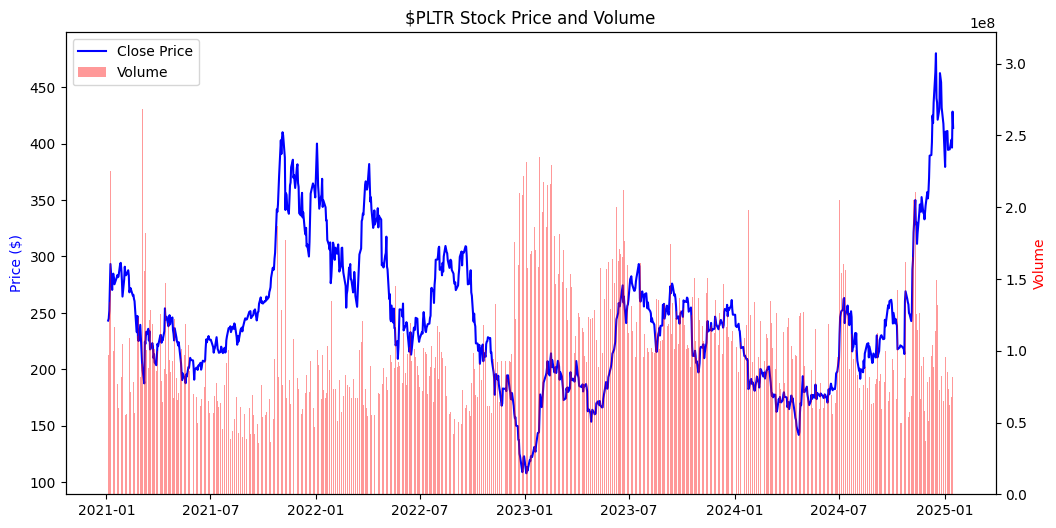

In [40]:
# Plot historical stock price and volume
plt.figure(figsize=(12, 6))
ax1 = plt.gca()  # Get current axes
ax2 = ax1.twinx()  # Create a second axes that shares the same x-axis

ax1.plot(data["Date"], data["Close"], label="Close Price", color="blue")
ax2.bar(data["Date"], data["Volume"], label="Volume", color="red", alpha=0.4)

ax1.set_title("$PLTR Stock Price and Volume")
ax1.set_ylabel("Price ($)", color="blue")
ax2.set_ylabel("Volume", color="red")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()

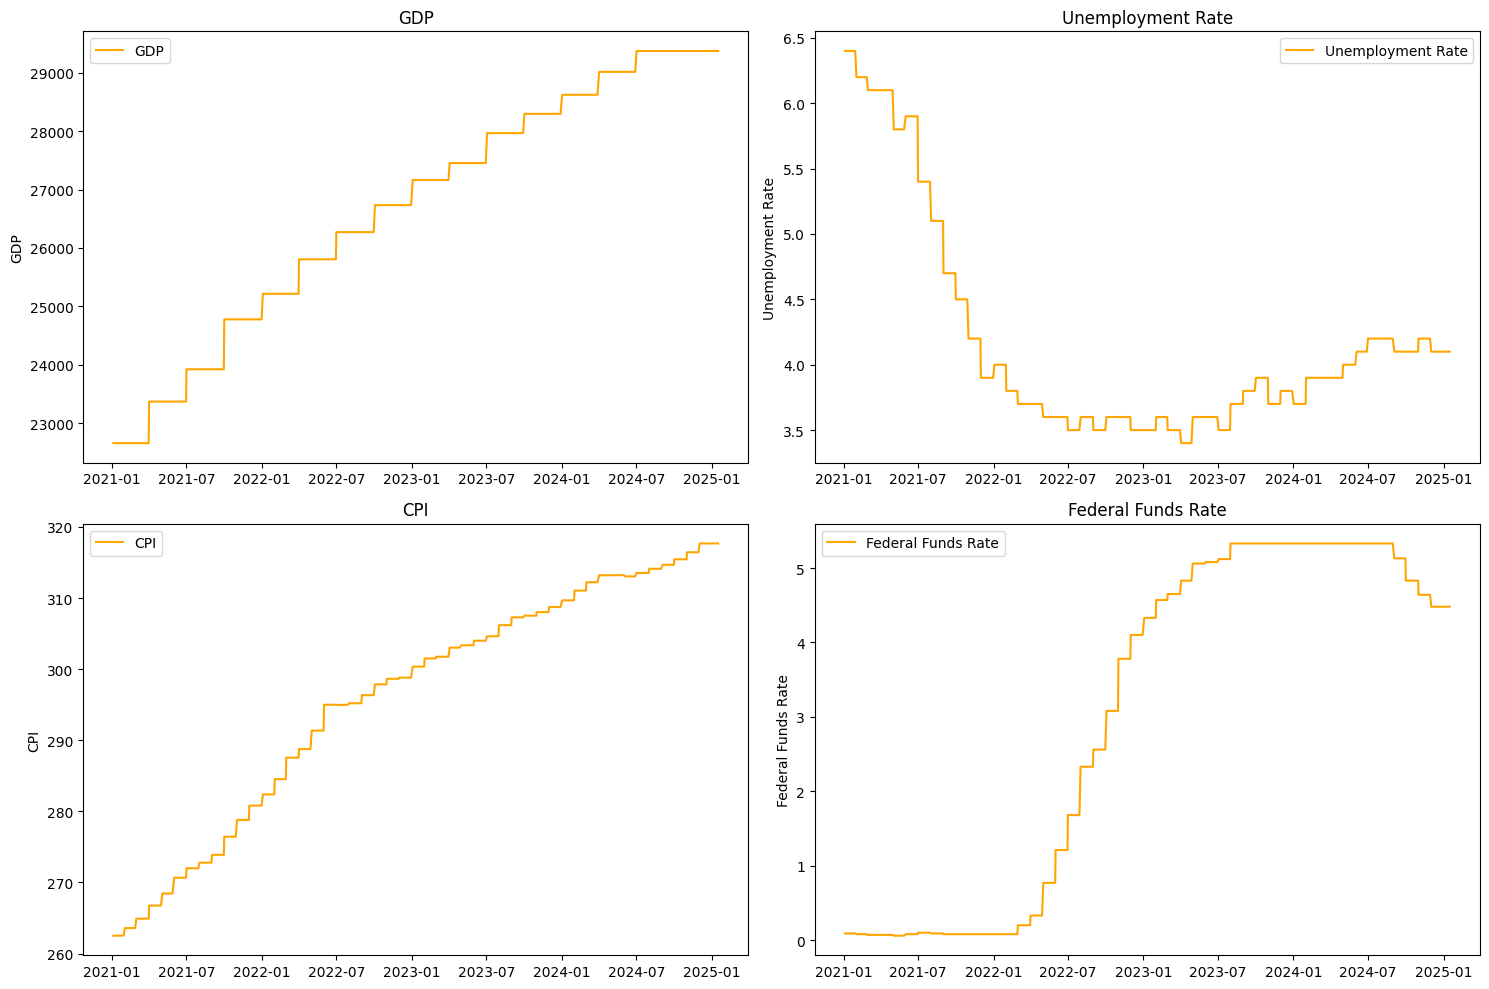

In [41]:
# Visualize economic indicators
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
indicators = ["GDP", "Unemployment Rate", "CPI", "Federal Funds Rate"]
for ax, indicator in zip(axes.flatten(), indicators):
    ax.plot(data["Date"], data[indicator], label=indicator, color="orange")
    ax.set_title(indicator)
    ax.set_ylabel(indicator)
    ax.legend()
plt.tight_layout()
plt.show()

## Feature Engineering
Feature engineering involves creating additional variables that improve the predictive power of our models. This step is critical for extracting actionable insights from raw data.

### Create Some Helpful Features
Examples of features include moving averages, volume trends, and relative strength indices (RSI). These features help capture patterns not directly visible in raw price data.

In [42]:
# Calculation of the RSI
def compute_rsi(data, window):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = compute_rsi(data['Close'], 14)

# Compute 1-day lag of the Close price
data['Close_1daylag'] = data['Close'].shift(1)

# Adding 50-day and 200-day Moving Average
data['Close_MA50'] = data['Close'].rolling(window=50, min_periods=1).mean()
data['Close_MA200'] = data['Close'].rolling(window=200, min_periods=1).mean()


In [43]:
data

,Date,Close,Open,High,Low,Volume,GDP,Unemployment Rate,CPI,Federal Funds Rate,10-Year Treasury Rate,RSI,Close_1daylag,Close_MA50,Close_MA200
0,2021-01-04,243.256668,239.820007,248.163330,239.063339,145914600,22656.793,6.4,262.518,0.09,0.93,NaN,NaN,243.256668,243.256668
1,2021-01-05,245.036667,241.220001,246.946671,239.733337,96735600,22656.793,6.4,262.518,0.09,0.96,100.000000,243.256668,244.146667,244.146667
2,2021-01-06,251.993332,252.830002,258.000000,249.699997,134100000,22656.793,6.4,262.518,0.09,1.04,100.000000,245.036667,246.762222,246.762222
3,2021-01-07,272.013336,259.209991,272.329987,258.399994,154496700,22656.793,6.4,262.518,0.09,1.08,100.000000,251.993332,253.075001,253.075001
4,2021-01-08,293.339996,285.333344,294.829987,279.463318,225166500,22656.793,6.4,262.518,0.09,1.13,100.000000,272.013336,261.128000,261.128000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,2025-01-10,394.739990,391.399994,399.279999,377.290009,62287300,29374.914,4.1,317.685,4.48,4.77,38.212225,394.940002,365.026199,245.576050
1011,2025-01-13,403.309998,383.209991,403.790009,380.070007,67580500,29374.914,4.1,317.685,4.48,4.79,41.665819,394.739990,367.901999,246.704250
1012,2025-01-14,396.359985,414.339996,422.640015,394.540009,84565000,29374.914,4.1,317.685,4.48,4.78,43.464915,403.309998,370.678199,247.786900
1013,2025-01-15,428.220001,409.899994,429.799988,405.660004,81375500,29374.914,4.1,317.685,4.48,4.66,49.436819,396.359985,374.245599,249.049050


In [44]:
# Extract features
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['weekday'] = data['Date'].dt.weekday;

In [45]:
# View dataframe
data = data.dropna()
data

,Date,Close,Open,High,Low,Volume,GDP,Unemployment Rate,CPI,Federal Funds Rate,10-Year Treasury Rate,RSI,Close_1daylag,Close_MA50,Close_MA200,year,month,day,weekday
1,2021-01-05,245.036667,241.220001,246.946671,239.733337,96735600,22656.793,6.4,262.518,0.09,0.96,100.000000,243.256668,244.146667,244.146667,2021,1,5,1
2,2021-01-06,251.993332,252.830002,258.000000,249.699997,134100000,22656.793,6.4,262.518,0.09,1.04,100.000000,245.036667,246.762222,246.762222,2021,1,6,2
3,2021-01-07,272.013336,259.209991,272.329987,258.399994,154496700,22656.793,6.4,262.518,0.09,1.08,100.000000,251.993332,253.075001,253.075001,2021,1,7,3
4,2021-01-08,293.339996,285.333344,294.829987,279.463318,225166500,22656.793,6.4,262.518,0.09,1.13,100.000000,272.013336,261.128000,261.128000,2021,1,8,4
5,2021-01-11,270.396667,283.133331,284.809998,267.873322,177904800,22656.793,6.4,262.518,0.09,1.15,68.582255,293.339996,262.672778,262.672778,2021,1,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,2025-01-10,394.739990,391.399994,399.279999,377.290009,62287300,29374.914,4.1,317.685,4.48,4.77,38.212225,394.940002,365.026199,245.576050,2025,1,10,4
1011,2025-01-13,403.309998,383.209991,403.790009,380.070007,67580500,29374.914,4.1,317.685,4.48,4.79,41.665819,394.739990,367.901999,246.704250,2025,1,13,0
1012,2025-01-14,396.359985,414.339996,422.640015,394.540009,84565000,29374.914,4.1,317.685,4.48,4.78,43.464915,403.309998,370.678199,247.786900,2025,1,14,1
1013,2025-01-15,428.220001,409.899994,429.799988,405.660004,81375500,29374.914,4.1,317.685,4.48,4.66,49.436819,396.359985,374.245599,249.049050,2025,1,15,2


## Forecasting Approaches
This section introduces different forecasting techniques, starting from simple baselines to advanced AI models.

### Split Data into Train and Test
To evaluate model performance, we split the data into training and testing subsets. The training set is used for building models, while the test set assesses their accuracy on an unseen dataset.

In [82]:
data

,Date,Close,Open,High,Low,Volume,GDP,Unemployment Rate,CPI,Federal Funds Rate,10-Year Treasury Rate,RSI,Close_1daylag,Close_MA50,Close_MA200,year,month,day,weekday,Close_tomorrow
1,2021-01-05,245.036667,241.220001,246.946671,239.733337,96735600,22656.793,6.4,262.518,0.09,0.96,100.000000,243.256668,244.146667,244.146667,2021,1,5,1,251.993332
2,2021-01-06,251.993332,252.830002,258.000000,249.699997,134100000,22656.793,6.4,262.518,0.09,1.04,100.000000,245.036667,246.762222,246.762222,2021,1,6,2,272.013336
3,2021-01-07,272.013336,259.209991,272.329987,258.399994,154496700,22656.793,6.4,262.518,0.09,1.08,100.000000,251.993332,253.075001,253.075001,2021,1,7,3,293.339996
4,2021-01-08,293.339996,285.333344,294.829987,279.463318,225166500,22656.793,6.4,262.518,0.09,1.13,100.000000,272.013336,261.128000,261.128000,2021,1,8,4,270.396667
5,2021-01-11,270.396667,283.133331,284.809998,267.873322,177904800,22656.793,6.4,262.518,0.09,1.15,68.582255,293.339996,262.672778,262.672778,2021,1,11,0,283.146667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,2025-01-07,394.359985,405.829987,414.329987,390.000000,75699500,29374.914,4.1,317.685,4.48,4.67,36.175095,411.049988,359.866599,243.344950,2025,1,7,1,394.940002
1009,2025-01-08,394.940002,392.950012,402.500000,387.399994,73038800,29374.914,4.1,317.685,4.48,4.67,31.703011,394.359985,362.381599,244.465500,2025,1,8,2,394.739990
1010,2025-01-10,394.739990,391.399994,399.279999,377.290009,62287300,29374.914,4.1,317.685,4.48,4.77,38.212225,394.940002,365.026199,245.576050,2025,1,10,4,403.309998
1011,2025-01-13,403.309998,383.209991,403.790009,380.070007,67580500,29374.914,4.1,317.685,4.48,4.79,41.665819,394.739990,367.901999,246.704250,2025,1,13,0,396.359985


In [83]:
# Define features and target
y_col = 'Close_tomorrow'
data[y_col] = data['Close'].shift(-1)
data = data.dropna()
X_cols = data.drop(columns=['Date', y_col]).columns.tolist()

print("Using columns:", X_cols)
print("With target variable:", y_col)
# Split data
X = data[X_cols]
y = data[y_col]

# Create train-test split
# 80% train, 20% train

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Using columns: ['Close', 'Open', 'High', 'Low', 'Volume', 'GDP', 'Unemployment Rate', 'CPI', 'Federal Funds Rate', '10-Year Treasury Rate', 'RSI', 'Close_1daylag', 'Close_MA50', 'Close_MA200', 'year', 'month', 'day', 'weekday']
With target variable: Close_tomorrow
Train size: 808
Test size: 203


<ipython-input-83-005b2705ad0f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



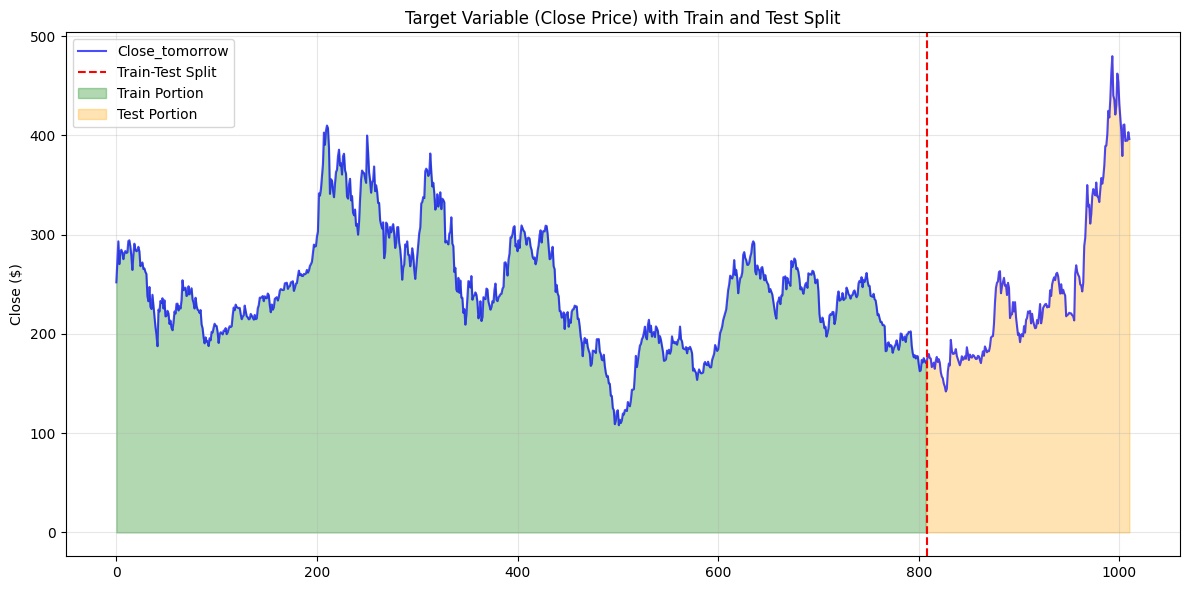

In [84]:
# Plot the target variable
plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), y, label=y_col, color='blue', alpha=0.7)
plt.axvline(train_size, color='red', linestyle='--', label='Train-Test Split')

# Highlight train and test portions
plt.fill_between(range(len(y)), y, where=(np.arange(len(y)) < train_size), color='green', alpha=0.3, label='Train Portion')
plt.fill_between(range(len(y)), y, where=(np.arange(len(y)) >= train_size), color='orange', alpha=0.3, label='Test Portion')

# Add labels, legend, and title
plt.title('Target Variable (Close Price) with Train and Test Split')
plt.ylabel('Close ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Forecast Approach 1) Naive Rolling Average
A simple baseline approach where predictions are based on rolling averages of historical data. This helps establish a benchmark for evaluating more advanced models.

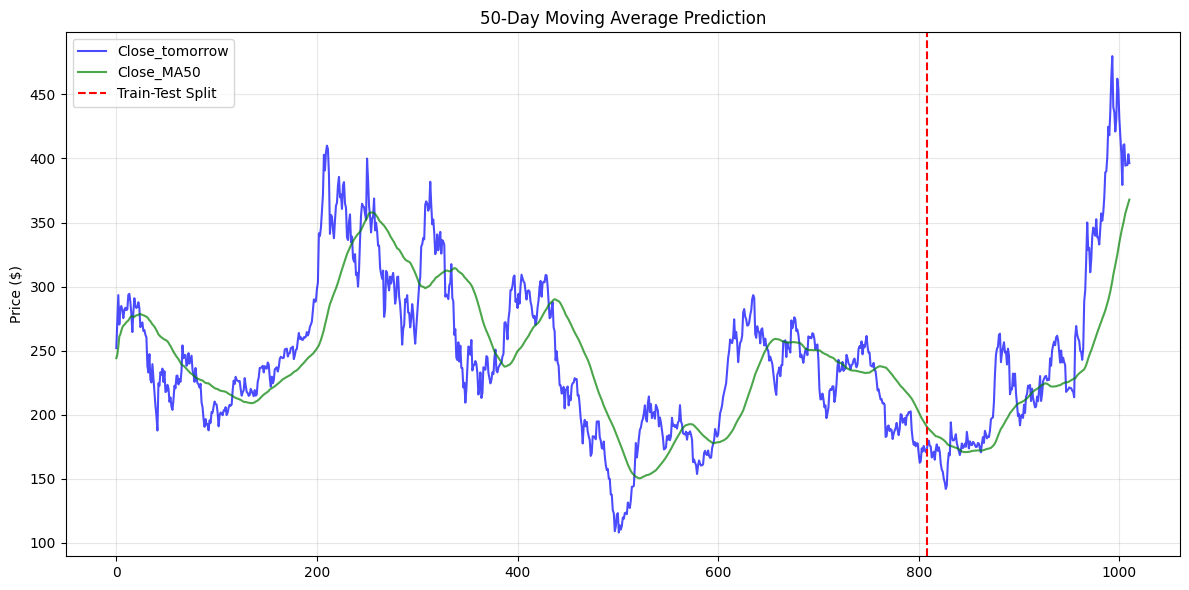

In [85]:

# Plot the target variable
plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), y, label=y_col, color='blue', alpha=0.7)
plt.plot(range(len(y)), X['Close_MA50'], label='Close_MA50', color='green', alpha=0.7)
plt.axvline(train_size, color='red', linestyle='--', label='Train-Test Split')

# Add labels, legend, and title
plt.title('50-Day Moving Average Prediction')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

#### Define function to compute our scoring metrics
For regression tasks, there are various scoring metrics like Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) to measure how close predictions are to actual values.

FOr stock prices, we typically care about relative error (in terms of %) - for that reason, we will use Mean Absolute Percent Error (MAPE) to evaluate models.

In [86]:
# For instruction purposes, lets compute MAPE ourselves
import numpy as np

def compute_mape(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    mape (array-like): mape is the Mean Absolute Percentage Error (in percentage)
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute MAPE, handling division by zero
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mape

y_pred = X_test['Close_MA50']
y_true = y_test
mape = compute_mape(y_true, y_pred)
print(f"MAPE for 50-day Moving Average: {mape:.2f}%")

## You can also use sklearn's built-in implementation:
# from sklearn.metrics import mean_absolute_percentage_error
# mape = mean_absolute_percentage_error(y_true, y_pred) * 100
# on average i am wrong by 11.34% using 30 day moving average


MAPE for 50-day Moving Average: 11.34%


In [87]:
# Another common baseline is simply predicting tomorrow's price to be the same as today's
y_pred = X_test['Close']
y_true = y_test
mape = compute_mape(y_true, y_pred)
print(f"MAPE for 1-day Lag of Target: {mape:.2f}%")

##will be on average the stock will move 3.01% on next day prediction

MAPE for 1-day Lag of Target: 3.01%


### Forecast Approach 2) Regression
Regression models utilize additional features to predict future stock prices. We'll explore linear regression and other variations for this task.

In [100]:
# [Naive implementation] Train and evaluate the Random Forest model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Train MAPE for Random Forest: 1.08%
Test MAPE for Random Forest: 3.68%


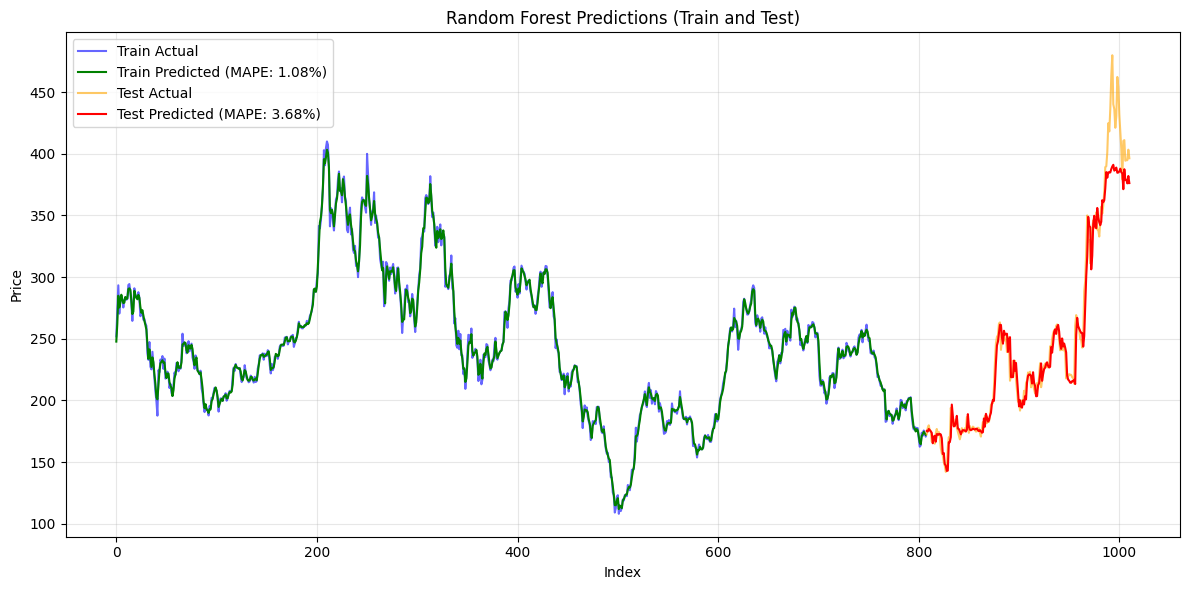

In [89]:
# compute MAPE
train_mape = compute_mape(y_train, train_predictions)
test_mape = compute_mape(y_test, test_predictions)
print(f"Train MAPE for Random Forest: {train_mape:.2f}%")
print(f"Test MAPE for Random Forest: {test_mape:.2f}%")

# Plot train data
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train, label="Train Actual", color="blue", alpha=0.6)
plt.plot(range(len(y_train)), train_predictions, label=f"Train Predicted (MAPE: {train_mape:.2f}%)", color="green")

# Plot test data
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label="Test Actual", color="orange", alpha=0.6)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predictions, label=f"Test Predicted (MAPE: {test_mape:.2f}%)", color="red")

# Add labels, legend, and title
plt.title("Random Forest Predictions (Train and Test)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

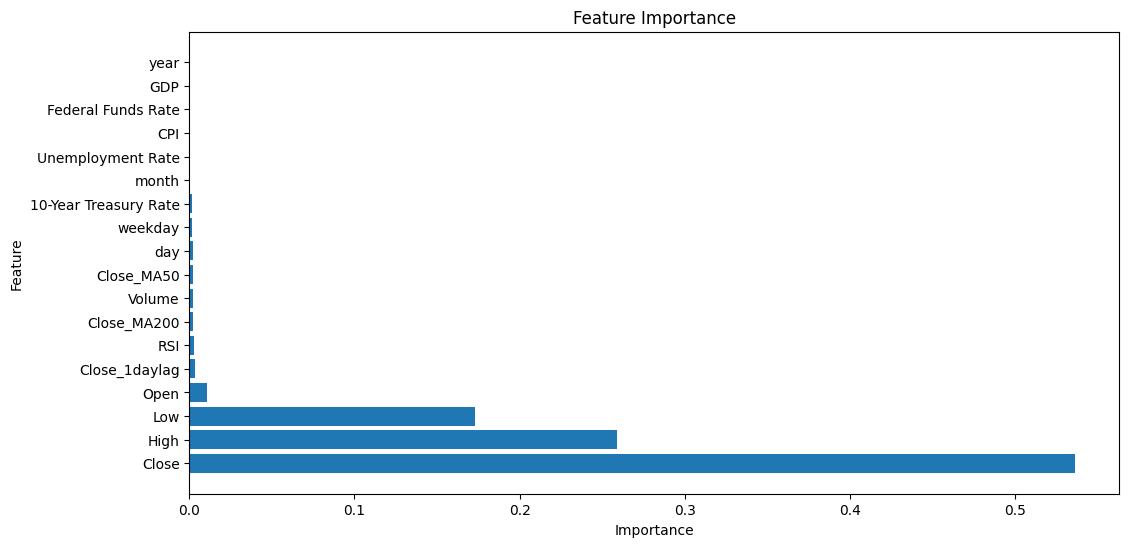

In [90]:
# What is driving our model predictions? View feature importance
feature_importances = model.feature_importances_

# Pair feature names with their importances
feature_importance_dict = dict(zip(X_train.columns, feature_importances))

# Sort features by importance in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the sorted feature importances
import pandas as pd
feature_importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])

# bar chart of feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

The mian features importance are: Close, high, Low, Open

### Forecast Approach 3) Prophet Forecasting
Prophet, developed by Facebook, is a robust forecasting tool that handles seasonality and trend shifts. It’s particularly useful for time-series data like stock prices.

In [91]:
from prophet import Prophet

# Create Prophet-compatible dataframe
prophet_data = data[['Date', y_col] + X_cols].rename(columns={'Date': 'ds', y_col: 'y'})
prophet_data = prophet_data.dropna()
prophet_data.reset_index(drop=True, inplace=True)

# Initialize the Prophet model and add exogenous regressors
model = Prophet()
for col in X_cols:
    model.add_regressor(col)

# Split data into train and test sets
train_size = int(0.8 * len(prophet_data))
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]

# Fit the model on training data
model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbee2hlc/pov4a4h6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbee2hlc/n8212gbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77592', 'data', 'file=/tmp/tmpfbee2hlc/pov4a4h6.json', 'init=/tmp/tmpfbee2hlc/n8212gbk.json', 'output', 'file=/tmp/tmpfbee2hlc/prophet_model8z34_3ho/prophet_model-20250118202542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [92]:
# Define the last date in the training data and the test data
last_train_date = prophet_data['ds'].iloc[train_size - 1]
last_test_date = test_data['ds'].iloc[-1]

# Calculate the number of days to forecast (periods)
periods = (last_test_date - last_train_date).days

future = model.make_future_dataframe(periods=periods, freq='D')
dates = set(prophet_data['ds'])
future = future[future['ds'].isin(dates)]
future.reset_index(drop=True, inplace=True)

# Add exogenous features to the future dataframe
for col in X_cols:
    future[col] = prophet_data[col]

future

,ds,Close,Open,High,Low,Volume,GDP,Unemployment Rate,CPI,Federal Funds Rate,10-Year Treasury Rate,RSI,Close_1daylag,Close_MA50,Close_MA200,year,month,day,weekday
0,2021-01-05,245.036667,241.220001,246.946671,239.733337,96735600,22656.793,6.4,262.518,0.09,0.96,100.000000,243.256668,244.146667,244.146667,2021,1,5,1
1,2021-01-06,251.993332,252.830002,258.000000,249.699997,134100000,22656.793,6.4,262.518,0.09,1.04,100.000000,245.036667,246.762222,246.762222,2021,1,6,2
2,2021-01-07,272.013336,259.209991,272.329987,258.399994,154496700,22656.793,6.4,262.518,0.09,1.08,100.000000,251.993332,253.075001,253.075001,2021,1,7,3
3,2021-01-08,293.339996,285.333344,294.829987,279.463318,225166500,22656.793,6.4,262.518,0.09,1.13,100.000000,272.013336,261.128000,261.128000,2021,1,8,4
4,2021-01-11,270.396667,283.133331,284.809998,267.873322,177904800,22656.793,6.4,262.518,0.09,1.15,68.582255,293.339996,262.672778,262.672778,2021,1,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,2025-01-06,411.049988,423.200012,426.429993,401.700012,85516500,29374.914,4.1,317.685,4.48,4.62,45.128081,410.440002,357.189000,242.237250,2025,1,6,0
1007,2025-01-07,394.359985,405.829987,414.329987,390.000000,75699500,29374.914,4.1,317.685,4.48,4.67,36.175095,411.049988,359.866599,243.344950,2025,1,7,1
1008,2025-01-08,394.940002,392.950012,402.500000,387.399994,73038800,29374.914,4.1,317.685,4.48,4.67,31.703011,394.359985,362.381599,244.465500,2025,1,8,2
1009,2025-01-10,394.739990,391.399994,399.279999,377.290009,62287300,29374.914,4.1,317.685,4.48,4.77,38.212225,394.940002,365.026199,245.576050,2025,1,10,4


In [93]:
# forecast
forecast = model.predict(future)

In [94]:
# compute MAPE
forecast = forecast.merge(prophet_data[['ds', 'y']], on='ds', how='left').dropna()
train_predictions = forecast['yhat'][:train_size]
test_predictions = forecast['yhat'][train_size:]

train_mape = compute_mape(forecast['y'][:train_size], train_predictions)
test_mape = compute_mape(forecast['y'][train_size:], test_predictions)
print(f"Train MAPE for Prophet Model: {train_mape:.2f}%")
print(f"Test MAPE for Prophet Model: {test_mape:.2f}%")

# Plot the results
from prophet.plot import plot_plotly

# Interactive forecast plot
plot_plotly(model, forecast)

Train MAPE for Prophet Model: 2.64%
Test MAPE for Prophet Model: 3.64%


In [95]:
# view the generated predictions
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,10-Year Treasury Rate,10-Year Treasury Rate_lower,10-Year Treasury Rate_upper,CPI,...,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2021-01-05,253.413117,238.446058,259.792829,253.413117,253.413117,8.341196,8.341196,8.341196,0.787325,...,11.066852,11.066852,0.196415,0.196415,0.196415,0.0,0.0,0.0,249.480187,251.993332
1,2021-01-06,253.342390,244.555507,266.116414,253.342390,253.342390,7.994229,7.994229,7.994229,0.787325,...,11.066852,11.066852,0.168959,0.168959,0.168959,0.0,0.0,0.0,255.130952,272.013336
2,2021-01-07,253.271663,262.374168,285.147071,253.271663,253.271663,7.820746,7.820746,7.820746,0.787325,...,11.066852,11.066852,0.108107,0.108107,0.108107,0.0,0.0,0.0,273.783520,293.339996
3,2021-01-08,253.200936,284.964436,307.253494,253.200936,253.200936,7.603893,7.603893,7.603893,0.787325,...,11.066852,11.066852,0.018474,0.018474,0.018474,0.0,0.0,0.0,295.958319,270.396667
4,2021-01-11,252.988755,262.806907,284.803841,252.988755,252.988755,7.517151,7.517151,7.517151,0.787325,...,11.066852,11.066852,-0.366641,-0.366641,-0.366641,0.0,0.0,0.0,273.760294,283.146667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,2025-01-06,245.307794,386.285907,408.618564,242.980322,247.810198,-7.532503,-7.532503,-7.532503,-0.738567,...,-27.853785,-27.853785,0.168959,0.168959,0.168959,0.0,0.0,0.0,397.062704,394.359985
1007,2025-01-07,245.309964,369.801399,391.799685,242.960218,247.833637,-7.749356,-7.749356,-7.749356,-0.738567,...,-27.853785,-27.853785,0.108107,0.108107,0.108107,0.0,0.0,0.0,380.642818,394.940002
1008,2025-01-08,245.312134,367.335726,390.348297,242.949637,247.852722,-7.749356,-7.749356,-7.749356,-0.738567,...,-27.853785,-27.853785,0.018474,0.018474,0.018474,0.0,0.0,0.0,378.622957,394.739990
1009,2025-01-10,245.316473,367.323490,391.973331,242.926722,247.879835,-8.183064,-8.183064,-8.183064,-0.738567,...,-27.853785,-27.853785,-0.225072,-0.225072,-0.225072,0.0,0.0,0.0,379.952632,403.309998


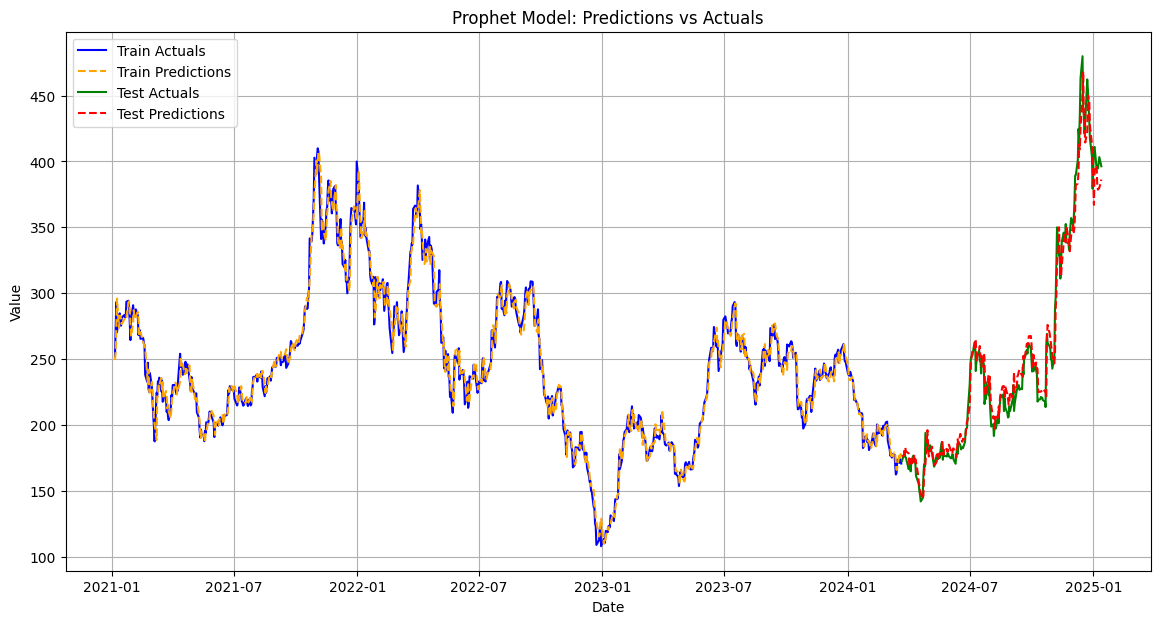

In [96]:
import matplotlib.pyplot as plt

# Extract actuals and predictions for train and test
train_actuals = forecast['y'][:train_size]
test_actuals = forecast['y'][train_size:]
train_predictions = forecast['yhat'][:train_size]
test_predictions = forecast['yhat'][train_size:]

# Create a plot
plt.figure(figsize=(14, 7))

# Plot train actuals vs. predictions
plt.plot(forecast['ds'][:train_size], train_actuals, label='Train Actuals', linestyle='-', color='blue')
plt.plot(forecast['ds'][:train_size], train_predictions, label='Train Predictions', linestyle='--', color='orange')

# Plot test actuals vs. predictions
plt.plot(forecast['ds'][train_size:], test_actuals, label='Test Actuals', linestyle='-', color='green')
plt.plot(forecast['ds'][train_size:], test_predictions, label='Test Predictions', linestyle='--', color='red')

# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Model: Predictions vs Actuals')
plt.legend()
plt.grid(True)
plt.show()




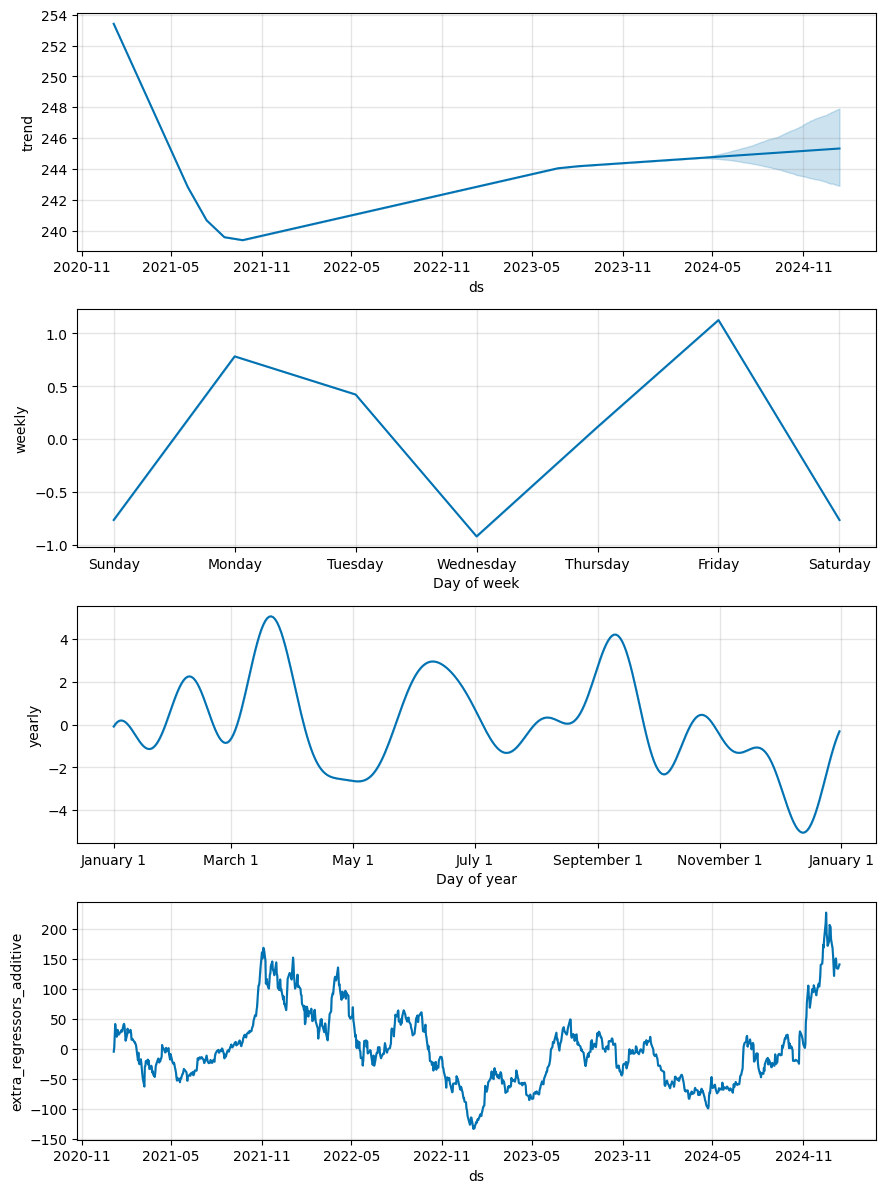

In [97]:
from prophet.plot import plot_components

# Plot decomposition of the forecast
fig_components = model.plot_components(forecast)
plt.show()

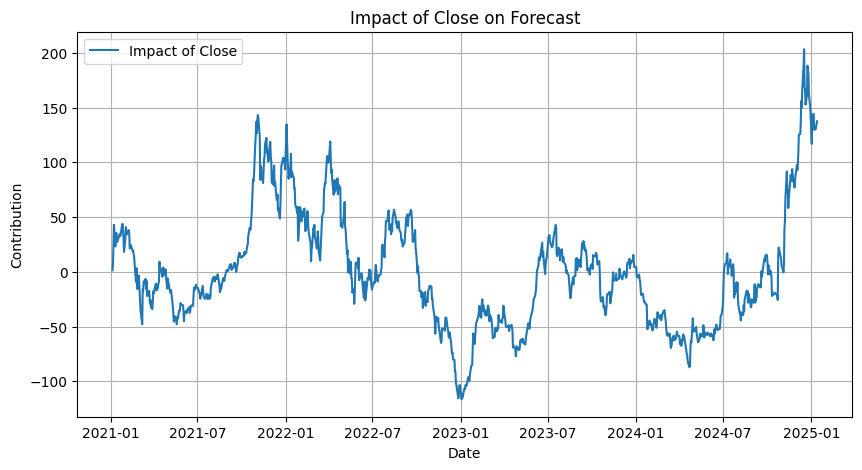

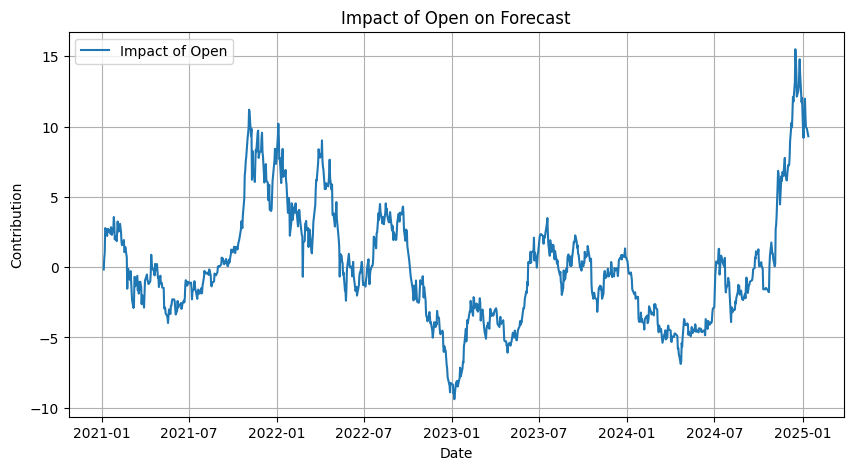

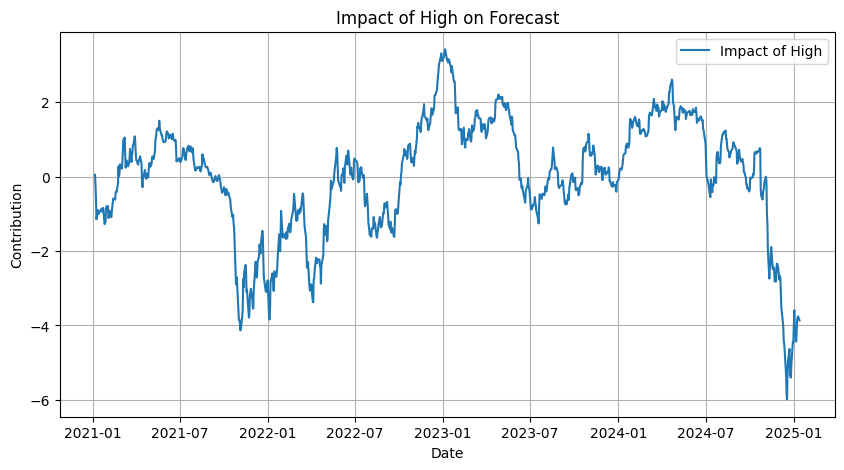

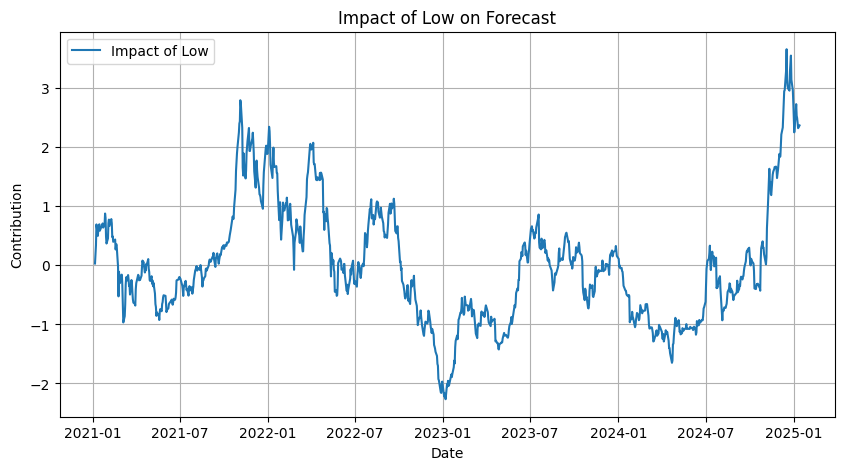

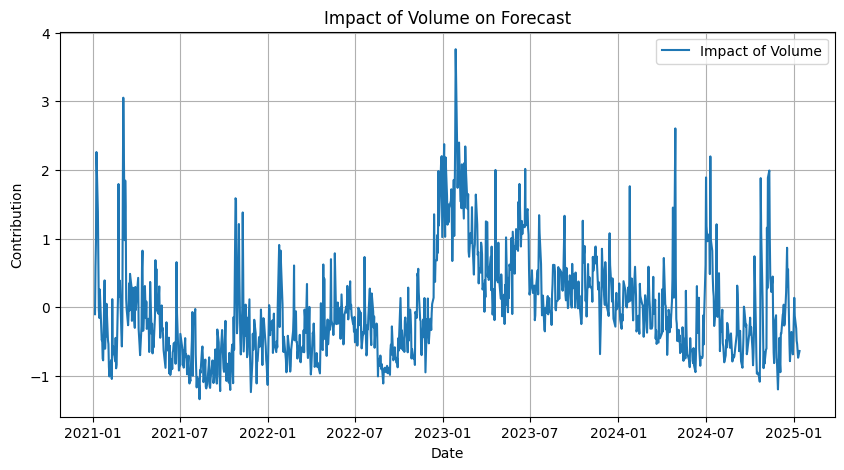

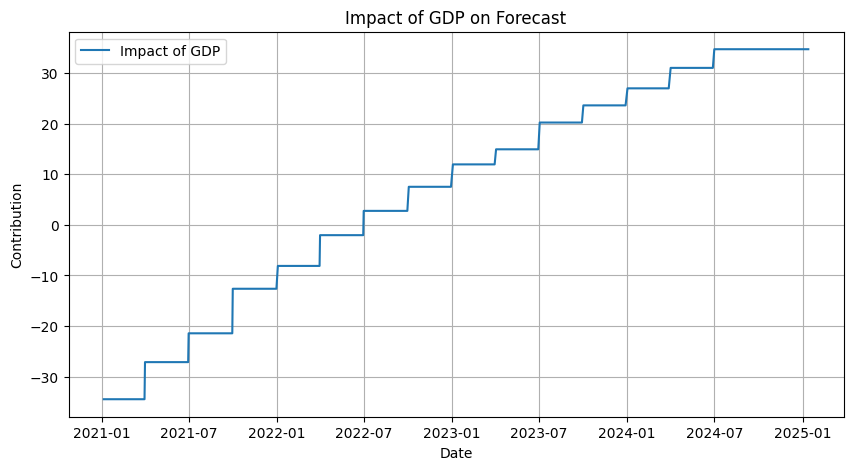

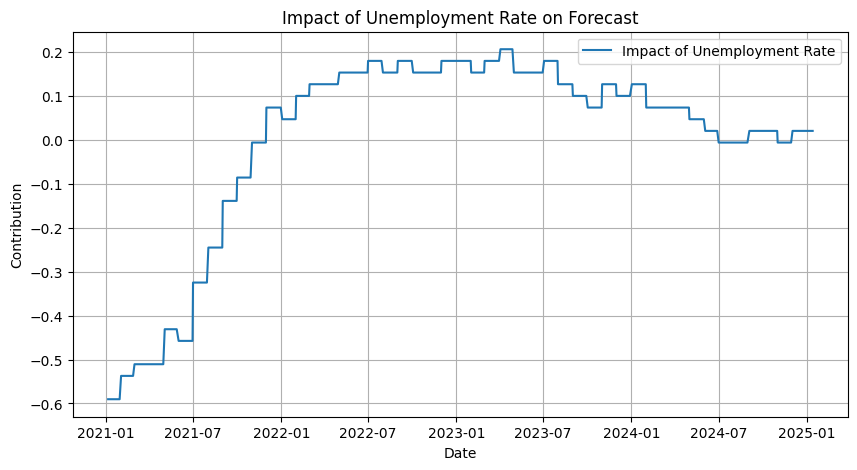

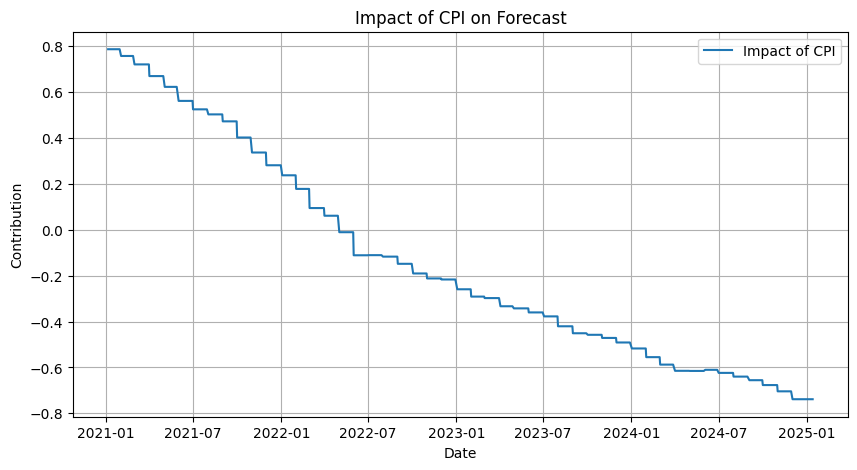

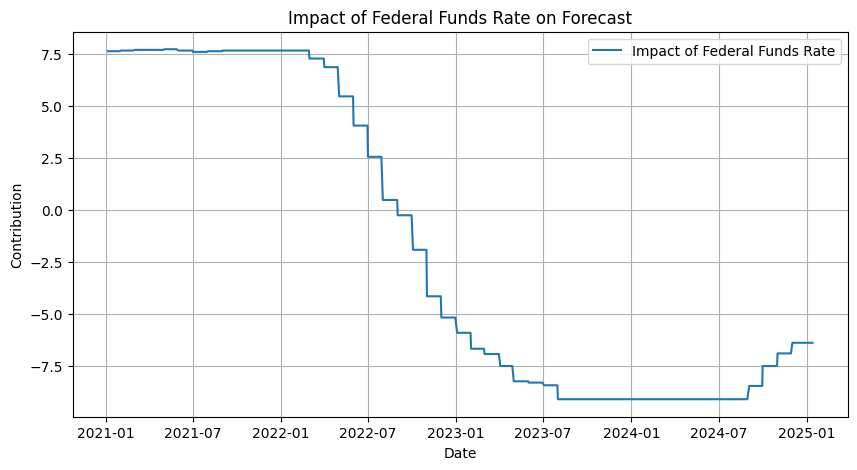

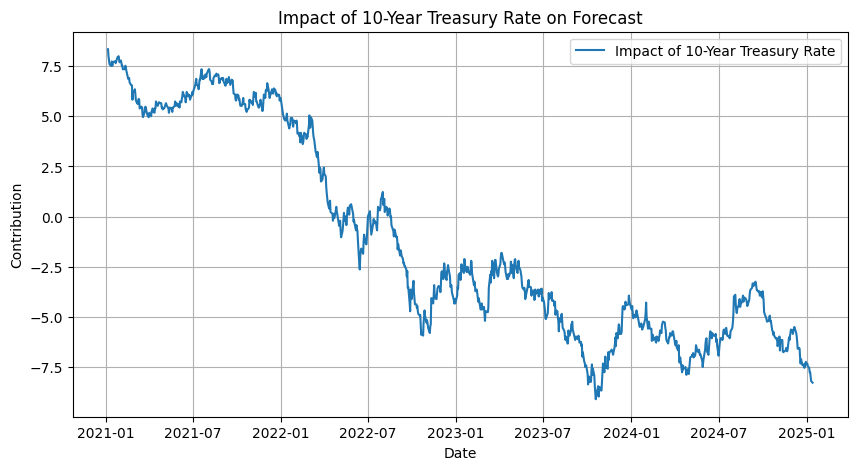

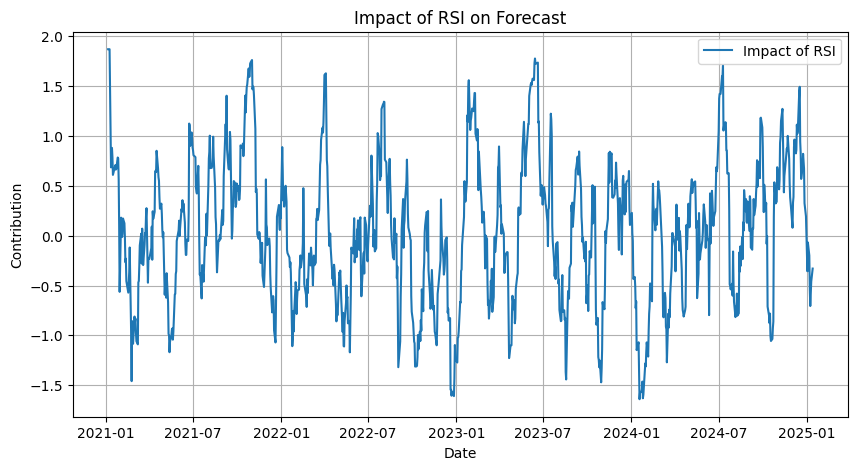

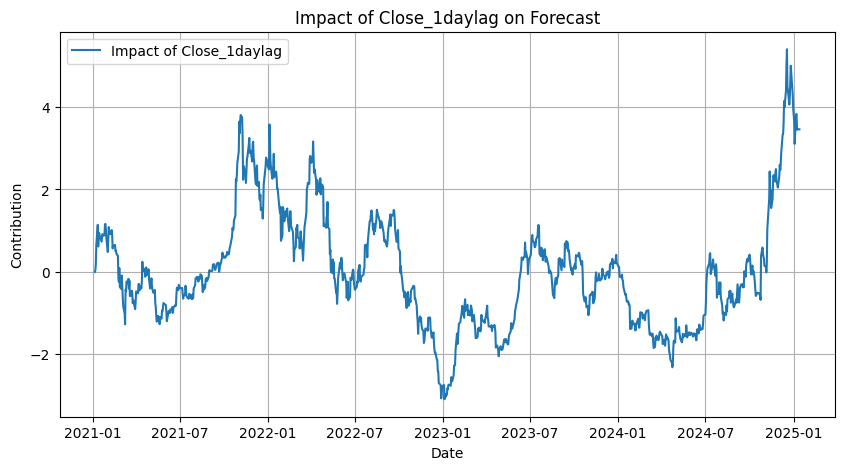

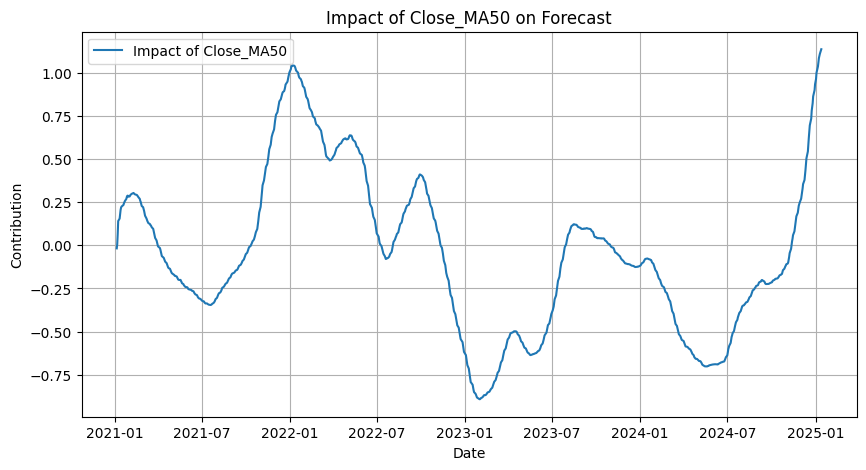

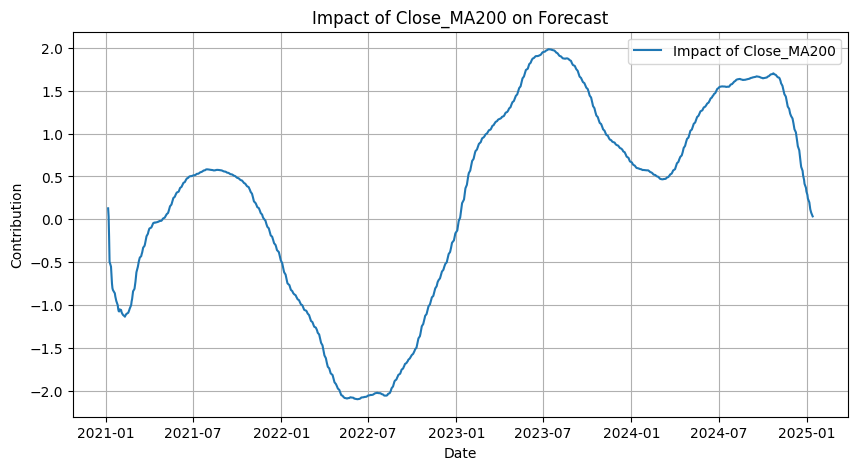

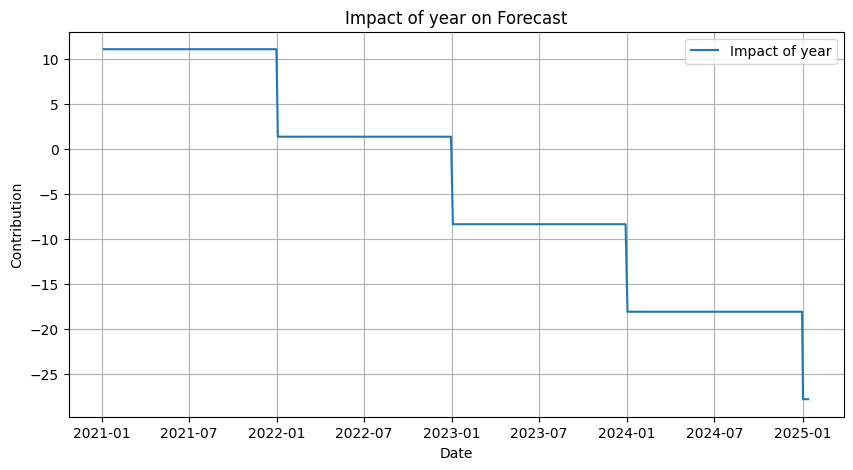

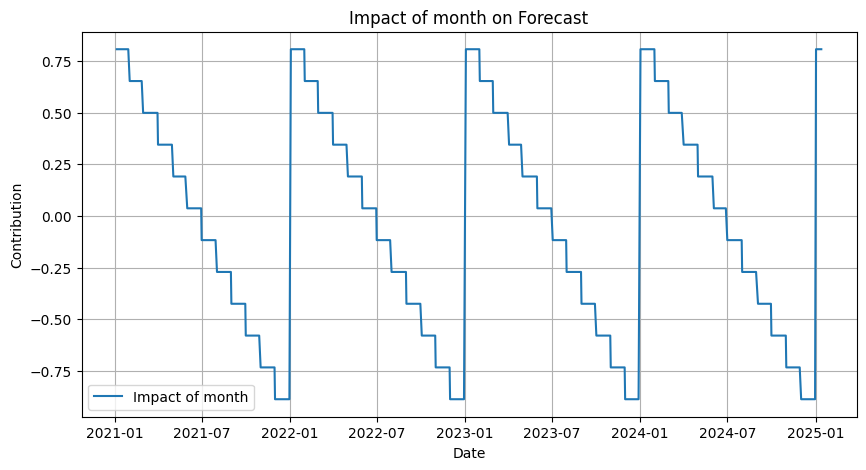

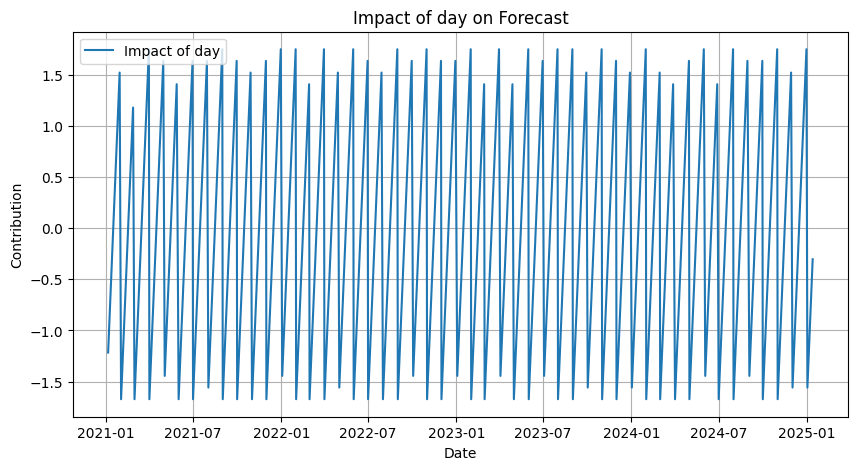

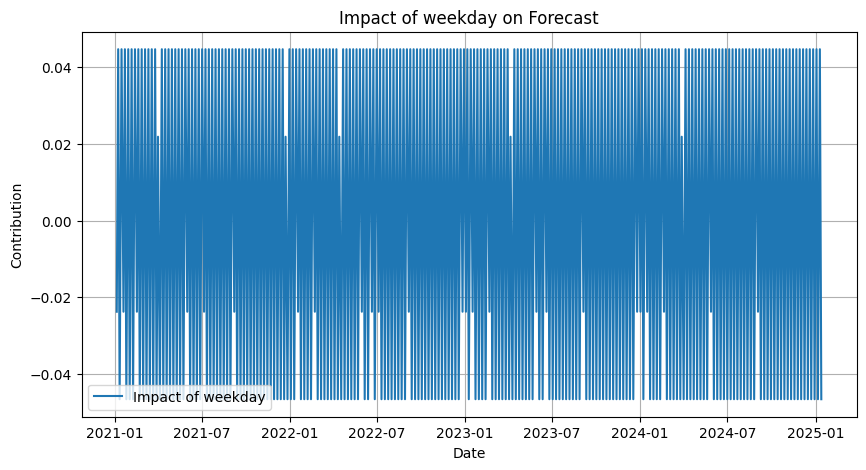

In [98]:
import matplotlib.pyplot as plt

# Plot the impact of each regressor
for regressor in X_cols:
    if regressor in forecast:
        plt.figure(figsize=(10, 5))
        plt.plot(forecast['ds'], forecast[regressor], label=f'Impact of {regressor}')
        plt.title(f'Impact of {regressor} on Forecast')
        plt.xlabel('Date')
        plt.ylabel('Contribution')
        plt.legend()
        plt.grid()
        plt.show()


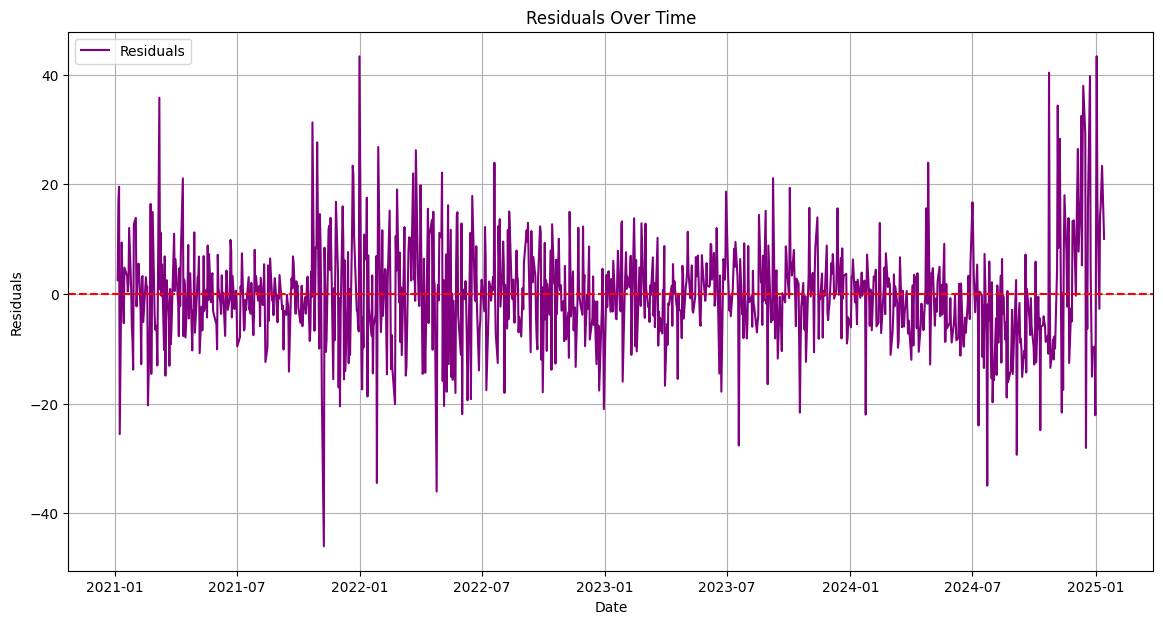

In [99]:
# Calculate residuals
forecast['residuals'] = forecast['y'] - forecast['yhat']

# Plot residuals over time
plt.figure(figsize=(14, 7))
plt.plot(forecast['ds'], forecast['residuals'], label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()